In [1]:
import numba
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Data preprocessing

#### Loading the data to a pandas data frame 

In [2]:
df = pd.read_csv("data/products", sep=",")

In [3]:
print("Number of items:",df.shape[0])
print("Number of attributes:", df.shape[1])

Number of items: 4089
Number of attributes: 18


In [4]:
# visualizing first 3 items
df.head(5)

,alto_plataforma,altura_cana,altura_taco,estilo,forma_punta,genero,horma,material,material_capellada,material_forro,material_suela,medida_taco,modelo,ocasion,temporada,tipo_broche,tipo_cana,tipo_taco
0,NaN,NaN,alto,NaN,redonda,mujer,normal,sintetico,NaN,sin informacion,sin informacion,NaN,rasen 96,NaN,primavera verano,NaN,NaN,NaN
1,NaN,NaN,alto,NaN,redonda,mujer,normal,gamuza,NaN,sin informacion,sin informacion,NaN,rasen 32,NaN,primavera verano,NaN,NaN,NaN
2,sin informacion,NaN,bajo,NaN,redonda,mujer,normal,textil,NaN,textil,goma,NaN,coronadoa70,NaN,primavera verano,NaN,NaN,cuadrado
3,sin informacion,NaN,bajo,NaN,redonda,mujer,normal,textil,NaN,textil,goma,NaN,coronadoa93,NaN,primavera verano,NaN,NaN,cuadrado
4,sin informacion,NaN,bajo,NaN,redonda,mujer,normal,sintetico,NaN,sin informacion,sin informacion,NaN,henrion62,NaN,otono invierno,NaN,NaN,cuadrado


In [5]:
# dtypes of attributes
df.dtypes

alto_plataforma       object
altura_cana           object
altura_taco           object
estilo                object
forma_punta           object
genero                object
horma                 object
material              object
material_capellada    object
material_forro        object
material_suela        object
medida_taco           object
modelo                object
ocasion               object
temporada             object
tipo_broche           object
tipo_cana             object
tipo_taco             object
dtype: object

Along the items in the dataset, there are multiple ways to indicate that is a lack of information for a given attribute. All these are mapped to `NaN`.

In [6]:
df.replace(to_replace="sin informacion", value=np.nan, inplace = True)
df.replace(to_replace="no disponible", value=np.nan, inplace = True)
df.replace(to_replace="n a", value=np.nan, inplace = True)
df.replace(to_replace="no aplica", value=np.nan, inplace = True)
df.replace(to_replace="", value=np.nan, inplace = True)
df.replace(to_replace=" ", value=np.nan, inplace = True)
df.head(5)

,alto_plataforma,altura_cana,altura_taco,estilo,forma_punta,genero,horma,material,material_capellada,material_forro,material_suela,medida_taco,modelo,ocasion,temporada,tipo_broche,tipo_cana,tipo_taco
0,NaN,NaN,alto,NaN,redonda,mujer,normal,sintetico,NaN,NaN,NaN,NaN,rasen 96,NaN,primavera verano,NaN,NaN,NaN
1,NaN,NaN,alto,NaN,redonda,mujer,normal,gamuza,NaN,NaN,NaN,NaN,rasen 32,NaN,primavera verano,NaN,NaN,NaN
2,NaN,NaN,bajo,NaN,redonda,mujer,normal,textil,NaN,textil,goma,NaN,coronadoa70,NaN,primavera verano,NaN,NaN,cuadrado
3,NaN,NaN,bajo,NaN,redonda,mujer,normal,textil,NaN,textil,goma,NaN,coronadoa93,NaN,primavera verano,NaN,NaN,cuadrado
4,NaN,NaN,bajo,NaN,redonda,mujer,normal,sintetico,NaN,NaN,NaN,NaN,henrion62,NaN,otono invierno,NaN,NaN,cuadrado


Since all values in the dataframe are categorical, we perform a numerical encoding over the dataset in order to make easier the comparison between items.

Below we inspect the values present in each of the columns/attributes:

In [7]:
for column in df.columns:
    print("Column: ", column)
    print(df[column].value_counts())
    print("\n")

Column:  alto_plataforma
3 cm       60
2 cm       59
1 cm       32
1          28
baja       23
4 cm       21
2          18
3          16
5 cm       13
4           9
10          4
7           3
redonda     3
6           3
7 cm        3
12 cm       3
0 cm        1
0 5 cm      1
0           1
1 4 cm      1
6 cm        1
Name: alto_plataforma, dtype: int64


Column:  altura_cana
7 cm      8
15 cm     3
7 3 cm    2
11        2
9         1
12        1
7         1
8 cm      1
12 cm     1
Name: altura_cana, dtype: int64


Column:  altura_taco
bajo        1115
alto         571
medio        258
sin taco     145
bajon         47
3 cm           9
2 5 cm         2
3 5 cm         1
1 5 cm         1
3 2 cm         1
2 cm           1
3 3 cm         1
Name: altura_taco, dtype: int64


Column:  estilo
zapatillas urbanas              45
urbana                          35
outdoor                         19
zapatillas escolar               7
zapatillas outdoor               7
zapatillas de running         

There are attributes that are intrinsically numerical, such as: `alto_plataforma`, `altura_cana`, `altura_taco` and `medida_taco`. 

At this point it is necessary to decide the type of enconding to use with the dataset. There are two standard approaches: The first approach is **label encoding** which maps categorical values to integer numbers. The second is **one hot encoding**. I decided the first one since one hot encodign would add to many columns to the dataset, then increasing to much the dimensionality of the data (course of dimensionality would probably appear).

Therefore, these numerical attibutes are mapped to categories as follow:

In [8]:
mappings = {
    "alto_plataforma" : {"0 cm":0, "0":0, "0 5 cm":0, "1":1, "1 cm":1, "2":2, "2 cm":2, "3":3, "3 cm": 3,
                        "4":4, "4 cm":4, "5":5, "5 cm":5, "6":6, "6 cm":6, "7":7, "7 cm":7, "8":8, "8 cm":8,
                        "9":9, "9 cm":9, "10":10, "10 cm":10, "12 cm":11, "1 4 cm": 12, "redonda":13, "baja":14},
    "altura_cana" : {"7":0, "7 cm":0, "7 3 cm":0, "8 cm":1, "9":2, "11":3, "12":4, "12 cm":4, "15 cm":5},
    "altura_taco" : {"sin taco":0, "bajo":1, "bajon":1, "medio":2, "alto":3, "1 5 cm":4, "2 cm":5, "2 5 cm":6,
                    "3 cm":7, "3 2 cm":7, "3 3 cm":7, "3 5 cm":8},
    "medida_taco" : {"1":0, "2":1, "2 cm":1, "3":2, "3 cm":2, "3 3 cm":2, "4 cm":3, "5 cm":4}
    
}

In [9]:
df.replace(mappings, inplace=True)

Verification that mappings were applied properly:

In [10]:
df["alto_plataforma"].value_counts()

2.0     77
3.0     76
1.0     60
4.0     30
14.0    23
5.0     13
7.0      6
10.0     4
6.0      4
13.0     3
0.0      3
11.0     3
12.0     1
Name: alto_plataforma, dtype: int64

In [11]:
df["altura_cana"].value_counts()

0.0    11
5.0     3
4.0     2
3.0     2
2.0     1
1.0     1
Name: altura_cana, dtype: int64

In [12]:
df["altura_taco"].value_counts()

1.0    1162
3.0     571
2.0     258
0.0     145
7.0      11
6.0       2
8.0       1
5.0       1
4.0       1
Name: altura_taco, dtype: int64

In [13]:
df["medida_taco"].value_counts()

2.0    28
1.0    14
3.0     2
4.0     1
0.0     1
Name: medida_taco, dtype: int64

Converting all the remaining categorical attributes to category. Note that we loop over the proviously converted attributes, but this doesn't causes any issue since they were already categorical.  

In [14]:
for column in df.columns:
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.codes

In [15]:
# dtypes of attributes
df.dtypes

alto_plataforma        int8
altura_cana            int8
altura_taco            int8
estilo                 int8
forma_punta            int8
genero                 int8
horma                  int8
material               int8
material_capellada     int8
material_forro         int8
material_suela         int8
medida_taco            int8
modelo                int16
ocasion                int8
temporada              int8
tipo_broche            int8
tipo_cana              int8
tipo_taco              int8
dtype: object

The previous encoding changed `NaN` values to `-1`. We reset this values to `NaN` again (will be better for the next step).

In [16]:
df.replace(to_replace=-1, value=np.nan, inplace = True)

Finally we convert the preprocessed pandas dataframe to a numpy array that we will use to compute the similarity metric.

In [17]:
dataset = df.as_matrix()

Removing rows which contain only `NaN` values:

In [18]:
m,n = dataset.shape
indexes = []
for i in range(m):
    if np.all(np.isnan(dataset[i,:])):
        indexes.append(i)
        
dataset = np.delete(dataset, indexes, axis=0)      

# numpy dataset array is serialized and saved
np.save("data/dataset.npy", dataset) 

# Similarity metric

The dataset is masked to ignore `NaN` values in the similarity computation.

In [19]:
print(dataset.shape)
mask = np.isnan(dataset)
valid = np.logical_not(mask)
dataset_masked = ma.masked_array(dataset, mask=mask)

(4075, 18)


The proposed similarity metric for items `i` and `j`, computes the coincidences for those items over all the categories, divided by the number of attributes. Note that `NaN` values are not considered in the search for coincidences. For this reason the similarity between `i` and `i` might not be `1`. I handled this by dividing each row of the similarity matrix by its corresponding diagonal entry. 

In this way all the values of the similarity matrix lies in `[0,1]`, with `0` indicating minimal similarity and `1` indicating maximal similarity.

In [20]:
# numba is used to speedup the computation through JIT
@numba.jit(nopython=True)
def similarity_matrix(dataset):
    n_samples,n_attr = dataset.shape
    smatrix = np.empty((n_samples,n_samples))
    for i in range(n_samples):
        for j in range(i,n_samples):
            smatrix[i,j] = np.sum(dataset[i]==dataset[j])/n_attr
            smatrix[j,i] = smatrix[i,j]
    
    for i in range(n_samples):
        # each row is scaled so that the diagonal value is 1,
        # since similirity between items (i,i) should be the same
        smatrix[i] /= smatrix[i,i]
    return smatrix

In [21]:
smatrix = similarity_matrix(dataset)
np.save("data/smatrix.npy", smatrix)

Below is a graphical view of the obtained similarity matrix. As you can see, this corresponds to a symetric matrix and with `1` values in the main diagonal. 

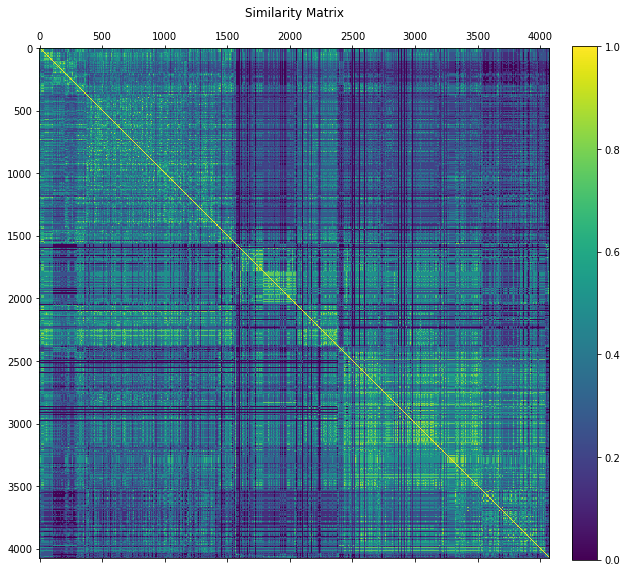

In [22]:
plt.figure(figsize=(10,10))
im = plt.matshow(smatrix, fignum=1)
#plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Similarity Matrix")
plt.show()